# Importando Drive (Caso for usar)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Instalando Bibliotecas

In [ ]:
!pip install cartopy metpy

# Script - Plot Individual


## Base de Cálculos

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import xarray as xr
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

import warnings
warnings.filterwarnings("ignore")

# Importa dados
ds = xr.open_dataset('/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/termo.nc')
ds = ds.metpy.parse_cf()

# Ajusta longitudes
ds['longitude'] = (((ds.longitude + 180) % 360) - 180).sortby('longitude')

# Recorte da área
lon_slice = slice(-45., -40.)
lat_slice = slice(-20., -24.)
ds = ds.sel(latitude=lat_slice, longitude=lon_slice, valid_time='2024-12-16T12:00:00')

# Extrai variáveis
p = ds.pressure_level.values * units.hPa
T = ds['t'].metpy.sel(vertical=p).values * units.kelvin
q = ds['q'].metpy.sel(vertical=p).values * units('kg/kg')
u = ds['u'].metpy.sel(vertical=p).values * units('m/s')
v = ds['v'].metpy.sel(vertical=p).values * units('m/s')

# Converte temperaturas e vento
T_C = T.to('degC')
Td = mpcalc.dewpoint_from_specific_humidity(p[:, None, None], T, q).to('degC')
u_kt = u.to('knots')
v_kt = v.to('knots')
wind_speed = mpcalc.wind_speed(u_kt, v_kt)
wind_dir = mpcalc.wind_direction(u_kt, v_kt)

# Inicializa arrays para armazenar os resultados
shape = (ds.latitude.size, ds.longitude.size)
cape_arr = np.full(shape, np.nan)
cin_arr = np.full(shape, np.nan)
dcape_arr = np.full(shape, np.nan)
kindex_arr = np.full(shape, np.nan)
total_totals_arr = np.full(shape, np.nan)
sweat_arr = np.full(shape, np.nan)
lifted_arr = np.full(shape, np.nan)
pw_arr = np.full(shape, np.nan)

# Loop em cada ponto da grade
for i, lat in enumerate(ds.latitude):
    for j, lon in enumerate(ds.longitude):
        try:
            t_prof = T_C[:, i, j]
            td_prof = Td[:, i, j]
            u_prof = u_kt[:, i, j]
            v_prof = v_kt[:, i, j]
            wspd = wind_speed[:, i, j]
            wdir = wind_dir[:, i, j]

            # Profile da parcela para índices
            prof = mpcalc.parcel_profile(p, t_prof[0], td_prof[0]).to('degC')

            # CAPE e CIN
            cape, cin = mpcalc.cape_cin(p, t_prof, td_prof, prof)
            cape_arr[i, j] = cape.m
            cin_arr[i, j] = cin.m

            # DCAPE
            dcape, _, _ = mpcalc.downdraft_cape(p, t_prof, td_prof)
            dcape_arr[i, j] = dcape.m

            # Índices
            kindex_arr[i, j] = mpcalc.k_index(p, t_prof, td_prof).m
            total_totals_arr[i, j] = mpcalc.total_totals_index(p, t_prof, td_prof).m
            sweat_arr[i, j] = mpcalc.sweat_index(p, t_prof, td_prof, wspd, wdir).m
            lifted_arr[i, j] = mpcalc.lifted_index(p, t_prof, prof).m

            # Água precipitável
            pw_arr[i, j] = mpcalc.precipitable_water(p, td_prof).to('mm').m

        except Exception:
            continue  # Pula pontos problemáticos

## CAPE

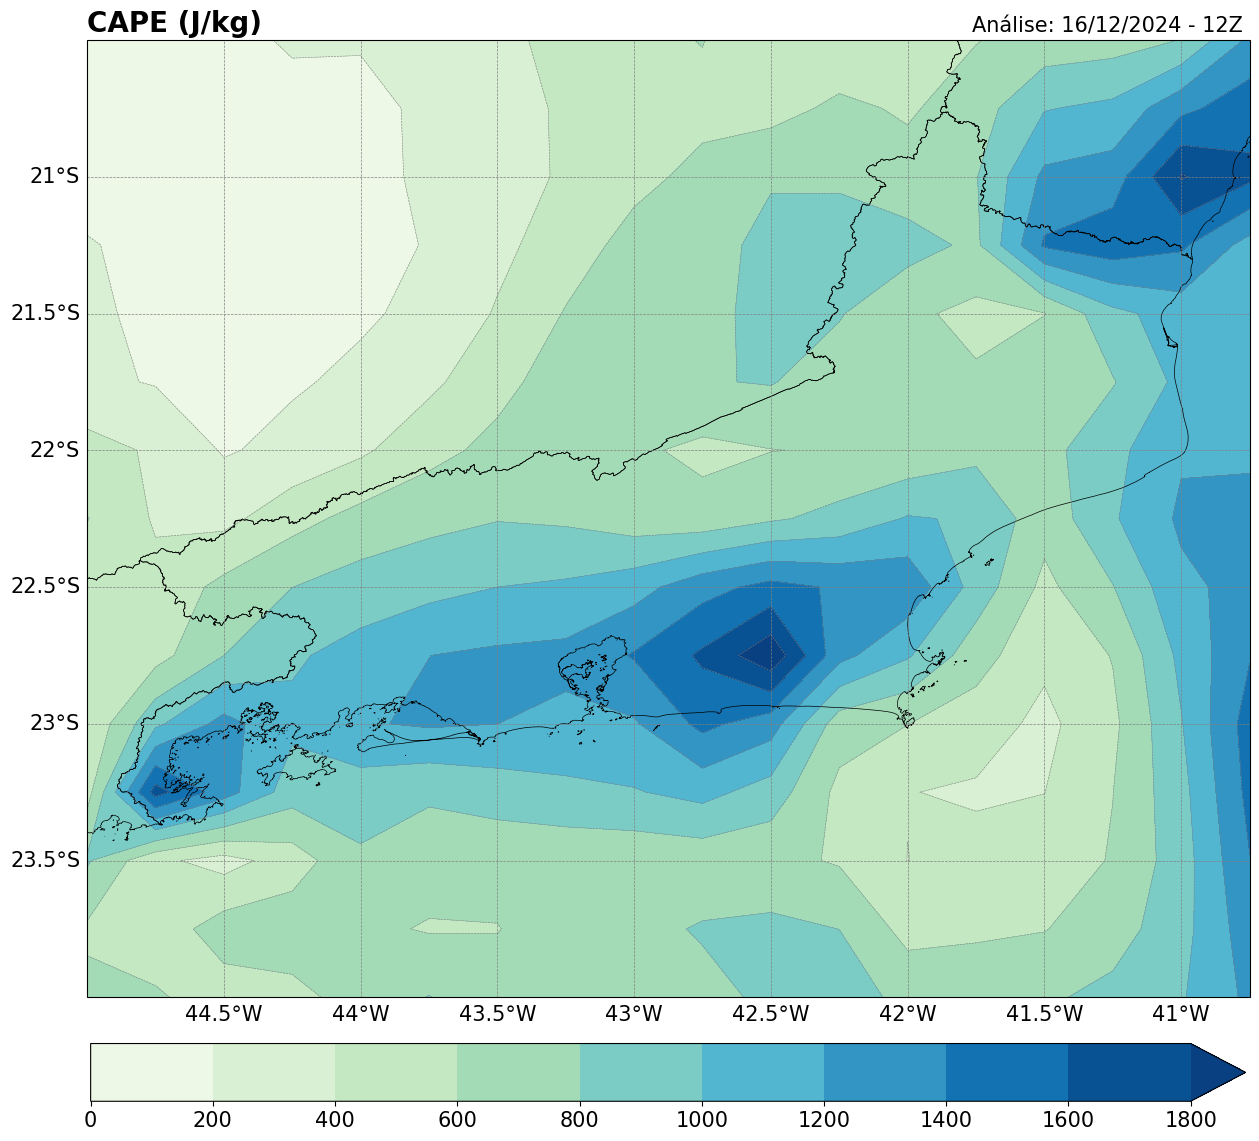

In [6]:
# Exemplo de plot do CAPE
plt.figure(figsize=(15,15))

# usando a projeção da coordenada cilindrica equidistante
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-45, -40.75, -24, -20.5], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  color='gray',
                  alpha=1.0,
                  linestyle='--',
                  linewidth=0.5,
                  xlocs=np.arange(-180, 180, 0.5),
                  ylocs=np.arange(-90, 90, 0.5),
                  draw_labels=True
                  )
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

cape = ax.contourf(ds.longitude,
                ds.latitude,
                cape_arr,
                cmap='GnBu',
                extend = 'max',
                levels=np.arange(0, 2000, 200))

ax.contour(ds.longitude,
            ds.latitude,
            cape_arr,
            colors = 'gray',
            linestyles = '--',
            linewidths = 0.4,
            levels=np.arange(0, 2200, 200))

shapefile = list(shpreader.Reader('/content/drive/MyDrive/Meteoro_UFRJ/Estágio Supervisionado 2 (Briefing)/Scripts/shapefiles/BR_UF_2021/BR_UF_2021.shp').geometries())

ax.add_geometries(shapefile,
                  ccrs.PlateCarree(),
                  edgecolor = 'black',
                  facecolor='none',
                  linewidth=0.5
                  )

barra_de_cores = plt.colorbar(cape,
                              orientation = 'horizontal',
                              pad=0.04,
                              fraction=0.05)

font_size = 15
barra_de_cores.ax.tick_params(labelsize=font_size)

# Add a title
plt.title('CAPE (J/kg)',
          fontweight='bold',
          fontsize=20,
          loc='left'
          )

# Titulo
plt.title('Análise: 16/12/2024 - 12Z ', fontsize=15, loc='right')

plt.savefig(f'/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/imagens/CAPE/CAPE.png', dpi=300, bbox_inches='tight')
plt.show()

## K Index

In [ ]:
# Exemplo de plot do K Index
plt.figure(figsize=(15,15))

# usando a projeção da coordenada cilindrica equidistante
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-45, -40.75, -24, -20.5], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  color='black',
                  alpha=1.0,
                  linestyle='--',
                  linewidth=0.5,
                  xlocs=np.arange(-180, 180, 0.5),
                  ylocs=np.arange(-90, 90, 0.5),
                  draw_labels=True
                  )
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

k_i = ax.contourf(ds.longitude,
                ds.latitude,
                kindex_arr,
                cmap='summer_r',
                levels=np.arange(15, 36, 3),
                extend = 'both')

ax.contour(ds.longitude,
            ds.latitude,
            kindex_arr,
            colors = 'gray',
            linestyles = '--',
            linewidths = 0.4,
            levels=np.arange(15, 36, 3))

shapefile = list(shpreader.Reader('/content/drive/MyDrive/Meteoro_UFRJ/Estágio Supervisionado 2 (Briefing)/Scripts/shapefiles/BR_UF_2021/BR_UF_2021.shp').geometries())

ax.add_geometries(shapefile,
                  ccrs.PlateCarree(),
                  edgecolor = 'black',
                  facecolor='none',
                  linewidth=0.5
                  )

barra_de_cores = plt.colorbar(k_i,
                              orientation = 'horizontal',
                              pad=0.04,
                              fraction=0.05)

font_size = 15
barra_de_cores.ax.tick_params(labelsize=font_size)

# Add a title
plt.title('K Index (°C)',
          fontweight='bold',
          fontsize=20,
          loc='left'
          )

# Titulo
plt.title('Análise: 16/12/2024 - 12Z ', fontsize=15, loc='right')

plt.savefig(f'/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/imagens/K_index/K_index.png', dpi=300, bbox_inches='tight')
plt.show()

## Sweat Index

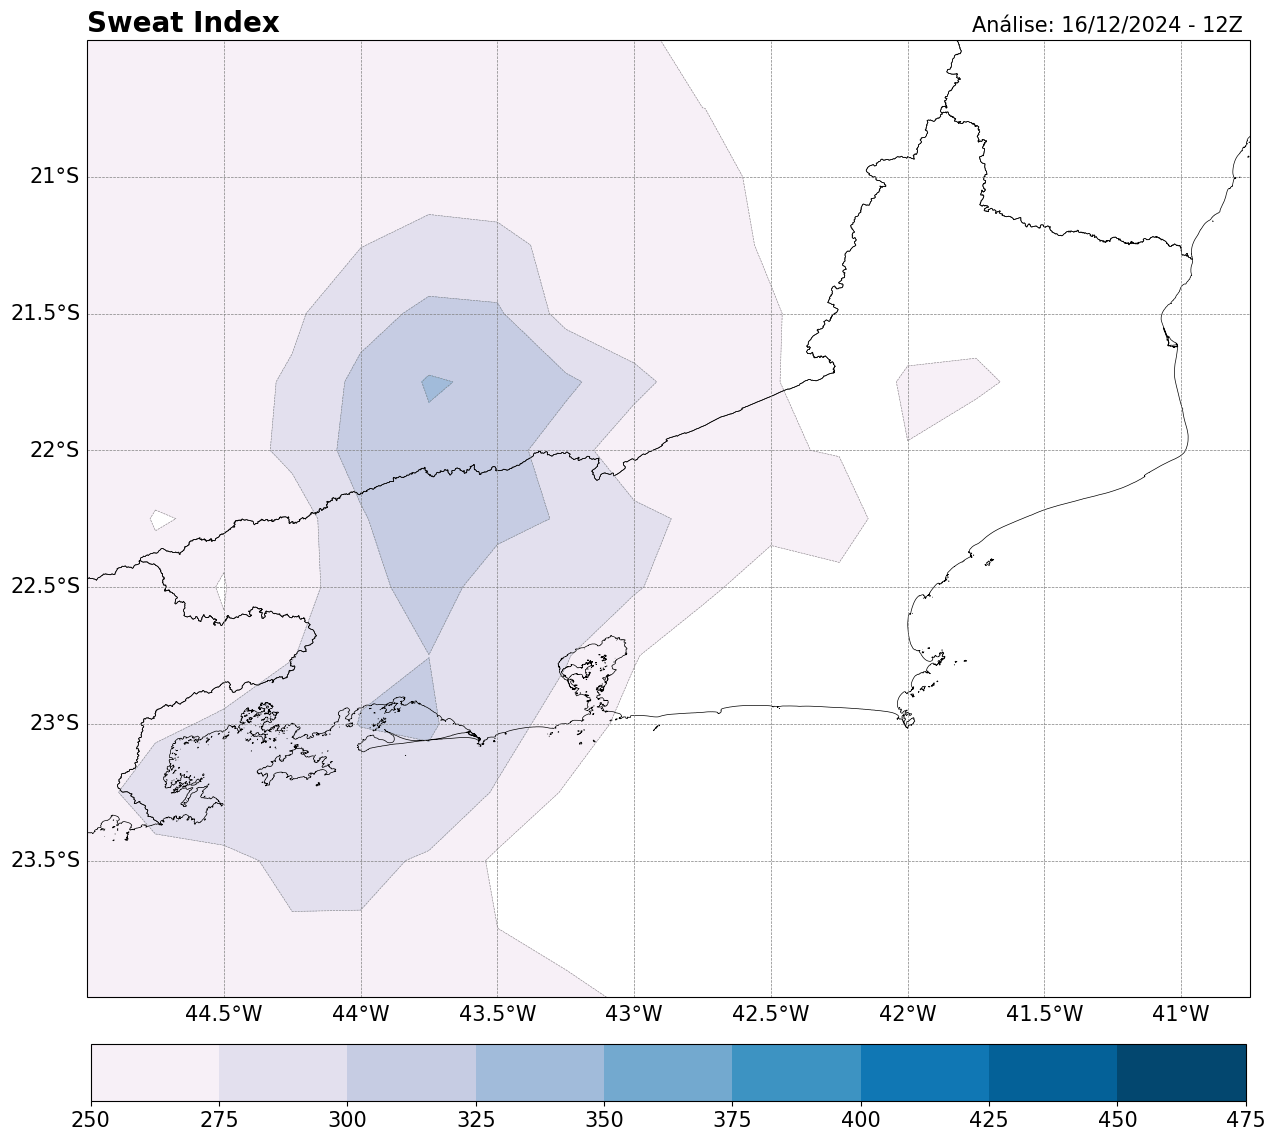

In [ ]:
# Exemplo de plot do Sweat Index
plt.figure(figsize=(15,15))

# usando a projeção da coordenada cilindrica equidistante
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-45, -40.75, -24, -20.5], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  color='gray',
                  alpha=1.0,
                  linestyle='--',
                  linewidth=0.5,
                  xlocs=np.arange(-180, 180, 0.5),
                  ylocs=np.arange(-90, 90, 0.5),
                  draw_labels=True
                  )
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

sweat_i = ax.contourf(ds.longitude,
                ds.latitude,
                sweat_arr,
                cmap='PuBu',
                levels=np.arange(250, 500, 25))

ax.contour(ds.longitude,
            ds.latitude,
            sweat_arr,
            colors = 'gray',
            linestyles = '--',
            linewidths = 0.4,
            levels=np.arange(250, 500, 25))

shapefile = list(shpreader.Reader('/content/drive/MyDrive/Meteoro_UFRJ/Estágio Supervisionado 2 (Briefing)/Scripts/shapefiles/BR_UF_2021/BR_UF_2021.shp').geometries())

ax.add_geometries(shapefile,
                  ccrs.PlateCarree(),
                  edgecolor = 'black',
                  facecolor='none',
                  linewidth=0.5
                  )

barra_de_cores = plt.colorbar(sweat_i,
                              orientation = 'horizontal',
                              pad=0.04,
                              fraction=0.05)

font_size = 15
barra_de_cores.ax.tick_params(labelsize=font_size)

# Add a title
plt.title('Sweat Index',
          fontweight='bold',
          fontsize=20,
          loc='left'
          )

# Titulo
plt.title('Análise: 16/12/2024 - 12Z ', fontsize=15, loc='right')

plt.savefig(f'/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/imagens/SweatI/Swwat_I.png', dpi=300, bbox_inches='tight')
plt.show()

## Total Totals Index

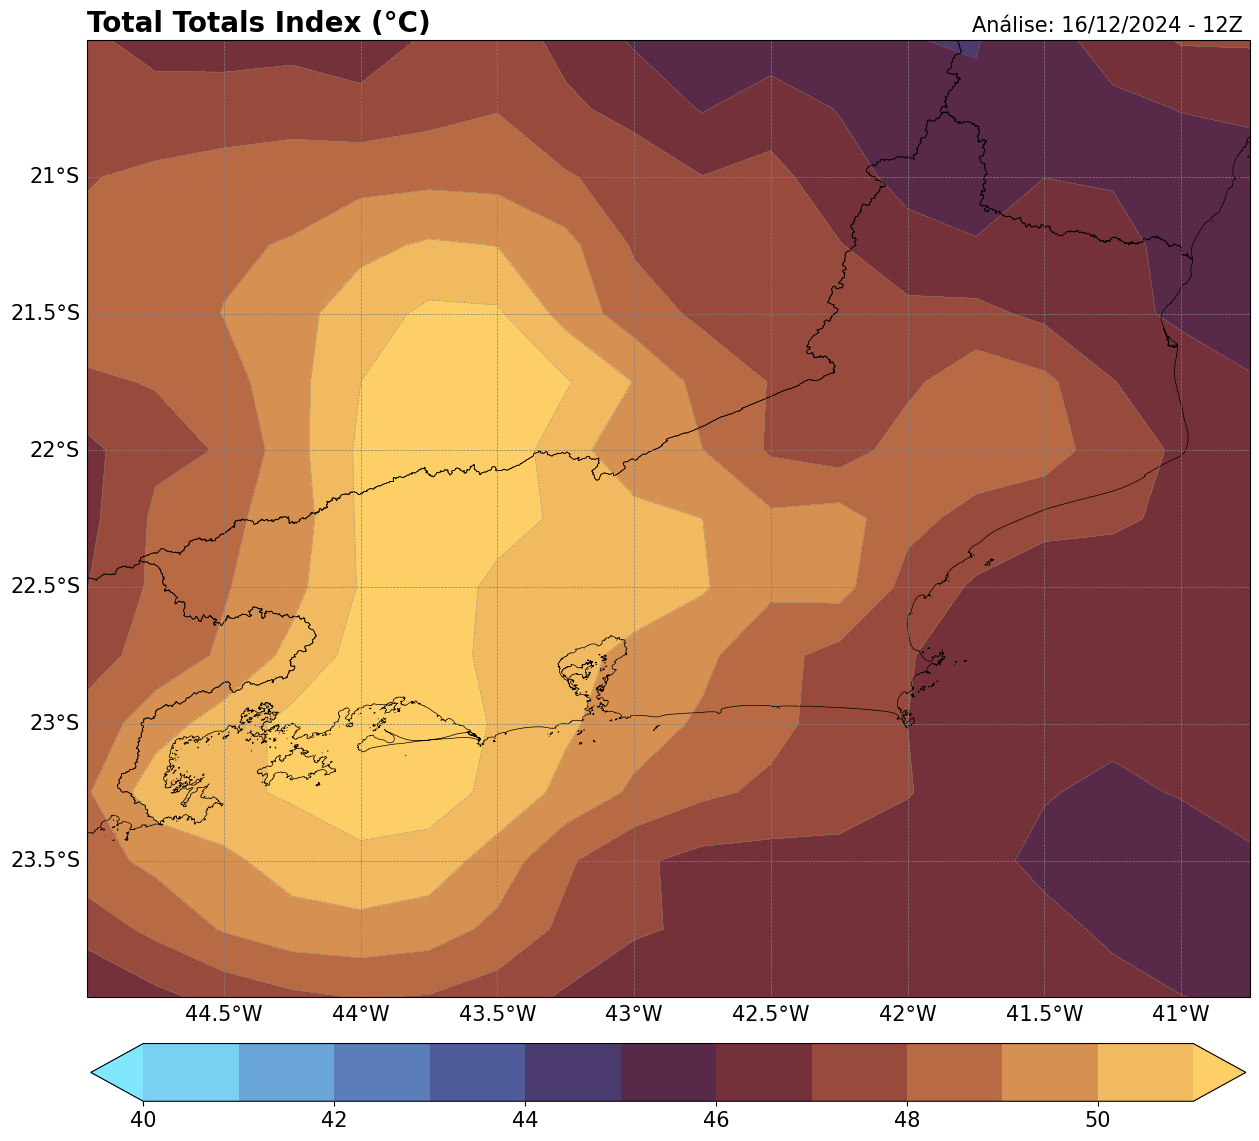

In [7]:
# Exemplo de plot do Total Totals
plt.figure(figsize=(15,15))

# usando a projeção da coordenada cilindrica equidistante
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-45, -40.75, -24, -20.5], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  color='gray',
                  alpha=1.0,
                  linestyle='--',
                  linewidth=0.5,
                  xlocs=np.arange(-180, 180, 0.5),
                  ylocs=np.arange(-90, 90, 0.5),
                  draw_labels=True
                  )
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

tt_i = ax.contourf(ds.longitude,
                ds.latitude,
                total_totals_arr,
                cmap='managua_r',
                levels=np.arange(40, 52, 1),
                extend = 'both')

ax.contour(ds.longitude,
            ds.latitude,
            total_totals_arr,
            colors = 'gray',
            linestyles = '--',
            linewidths = 0.4,
            levels=np.arange(40, 52, 1),
            extend = 'both')

shapefile = list(shpreader.Reader('/content/drive/MyDrive/Meteoro_UFRJ/Estágio Supervisionado 2 (Briefing)/Scripts/shapefiles/BR_UF_2021/BR_UF_2021.shp').geometries())

ax.add_geometries(shapefile,
                  ccrs.PlateCarree(),
                  edgecolor = 'black',
                  facecolor='none',
                  linewidth=0.5
                  )

barra_de_cores = plt.colorbar(tt_i,
                              orientation = 'horizontal',
                              pad=0.04,
                              fraction=0.05)

font_size = 15
barra_de_cores.ax.tick_params(labelsize=font_size)

# Add a title
plt.title('Total Totals Index (°C)',
          fontweight='bold',
          fontsize=20,
          loc='left'
          )

# Titulo
plt.title('Análise: 16/12/2024 - 12Z ', fontsize=15, loc='right')

plt.savefig(f'/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/imagens/TT/TT.png', dpi=300, bbox_inches='tight')
plt.show()

## Lifted Index

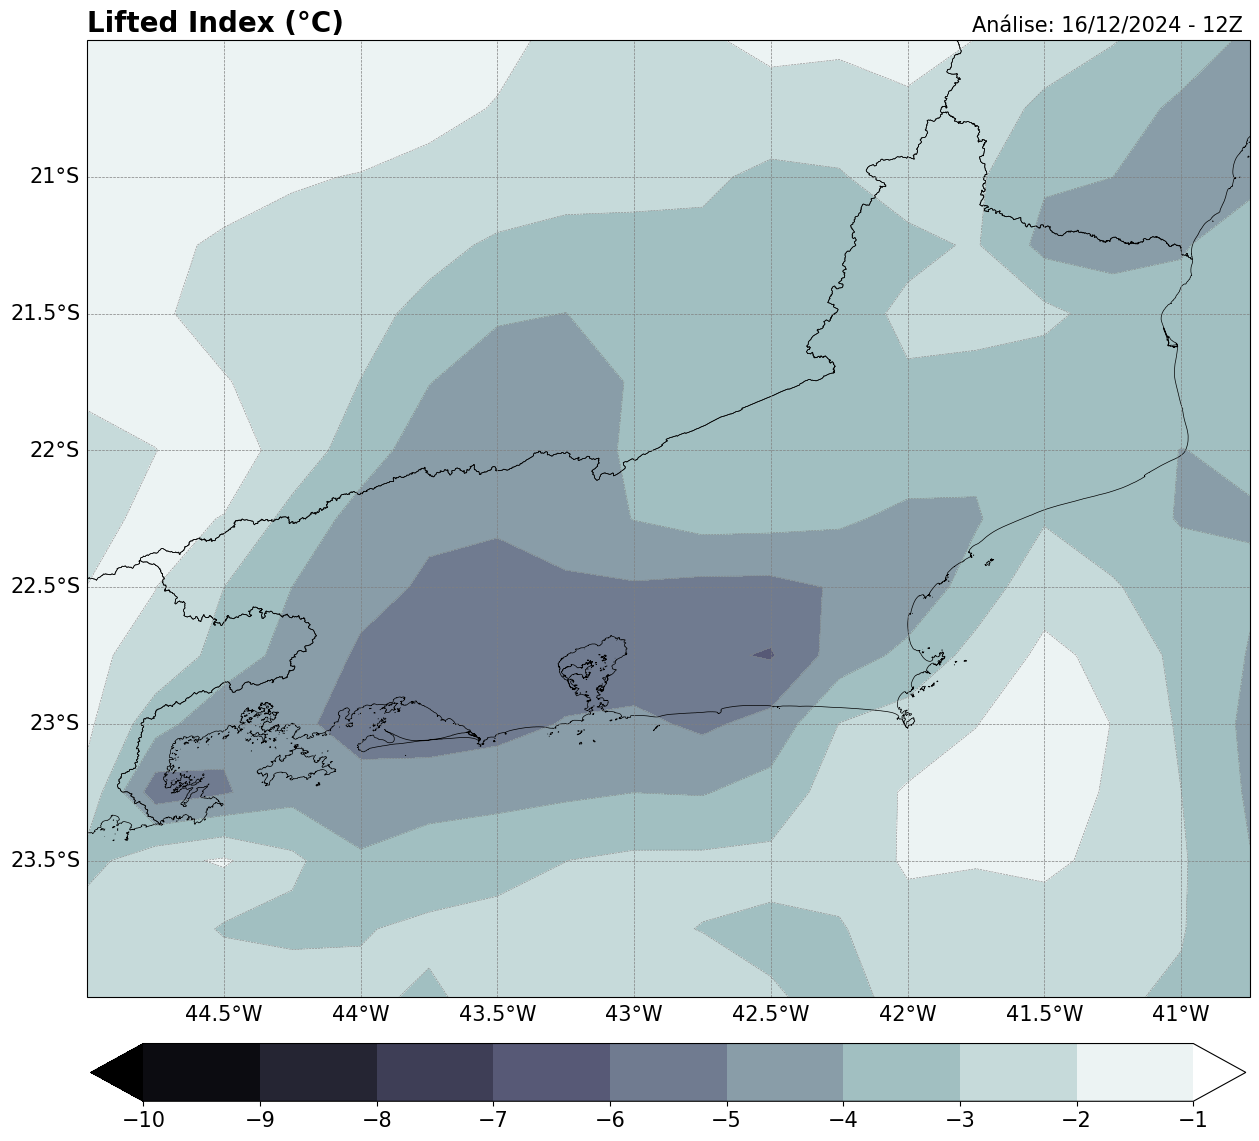

In [ ]:
# Exemplo de plot do Lifted Index
plt.figure(figsize=(15,15))

# usando a projeção da coordenada cilindrica equidistante
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-45, -40.75, -24, -20.5], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  color='gray',
                  alpha=1.0,
                  linestyle='--',
                  linewidth=0.5,
                  xlocs=np.arange(-180, 180, 0.5),
                  ylocs=np.arange(-90, 90, 0.5),
                  draw_labels=True
                  )
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

li_i = ax.contourf(ds.longitude,
                ds.latitude,
                lifted_arr,
                cmap='bone',
                levels=np.arange(-10, 0, 1),
                extend = 'both')

ax.contour(ds.longitude,
            ds.latitude,
            lifted_arr,
            colors = 'gray',
            linestyles = '--',
            linewidths = 0.4,
            levels=np.arange(-10, 0, 1),
            extend = 'both')

shapefile = list(shpreader.Reader('/content/drive/MyDrive/Meteoro_UFRJ/Estágio Supervisionado 2 (Briefing)/Scripts/shapefiles/BR_UF_2021/BR_UF_2021.shp').geometries())

ax.add_geometries(shapefile,
                  ccrs.PlateCarree(),
                  edgecolor = 'black',
                  facecolor='none',
                  linewidth=0.5
                  )

barra_de_cores = plt.colorbar(li_i,
                              orientation = 'horizontal',
                              pad=0.04,
                              fraction=0.05)

font_size = 15
barra_de_cores.ax.tick_params(labelsize=font_size)

# Add a title
plt.title('Lifted Index (°C)',
          fontweight='bold',
          fontsize=20,
          loc='left'
          )

# Titulo
plt.title('Análise: 16/12/2024 - 12Z ', fontsize=15, loc='right')

plt.savefig(f'/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/imagens/LI/LI.png', dpi=300, bbox_inches='tight')
plt.show()

## Precipitable Water (PWAT)

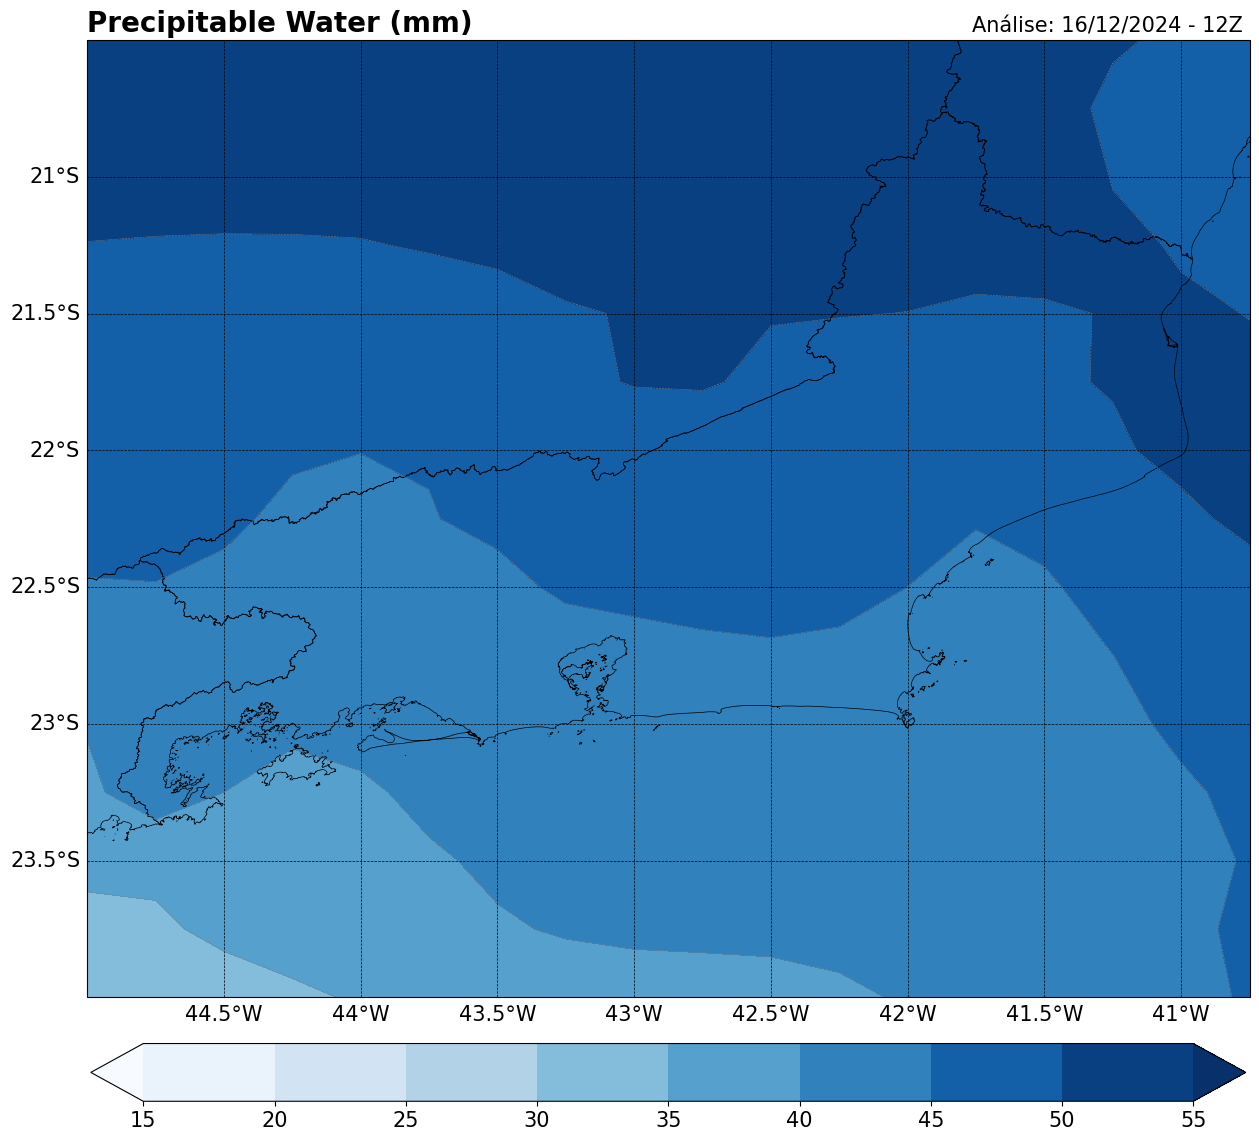

In [ ]:
# Exemplo de plot do Precitable Water
plt.figure(figsize=(15,15))

# usando a projeção da coordenada cilindrica equidistante
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-45, -40.75, -24, -20.5], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  color='black',
                  alpha=1.0,
                  linestyle='--',
                  linewidth=0.5,
                  xlocs=np.arange(-180, 180, 0.5),
                  ylocs=np.arange(-90, 90, 0.5),
                  draw_labels=True
                  )
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

pw_i = ax.contourf(ds.longitude,
                ds.latitude,
                pw_arr,
                cmap='Blues',
                levels=np.arange(15, 60, 5),
                extend = 'both')

ax.contour(ds.longitude,
            ds.latitude,
            pw_arr,
            colors = 'gray',
            linestyles = '--',
            linewidths = 0.4,
            levels=np.arange(15, 60, 5),
            extend = 'both')

shapefile = list(shpreader.Reader('/content/drive/MyDrive/Meteoro_UFRJ/Estágio Supervisionado 2 (Briefing)/Scripts/shapefiles/BR_UF_2021/BR_UF_2021.shp').geometries())

ax.add_geometries(shapefile,
                  ccrs.PlateCarree(),
                  edgecolor = 'black',
                  facecolor='none',
                  linewidth=0.5
                  )

barra_de_cores = plt.colorbar(pw_i,
                              orientation = 'horizontal',
                              pad=0.04,
                              fraction=0.05)

font_size = 15
barra_de_cores.ax.tick_params(labelsize=font_size)

# Add a title
plt.title('Precipitable Water (mm)',
          fontweight='bold',
          fontsize=20,
          loc='left'
          )

# Titulo
plt.title('Análise: 16/12/2024 - 12Z ', fontsize=15, loc='right')

plt.savefig(f'/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/imagens/pwat/pwat.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot de todos os índices Automáticos

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import xarray as xr
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

import warnings
warnings.filterwarnings("ignore")

# Importa dados
ds = xr.open_dataset('/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/termo.nc')
ds = ds.metpy.parse_cf()
ds['longitude'] = (((ds.longitude + 180) % 360) - 180).sortby('longitude')
ds = ds.sel(latitude=slice(-20., -24.), longitude=slice(-45., -40.)) # Mudar para a Lat/Lon desejada
ds = ds.sel(valid_time=slice('2024-12-16T12:00:00', '2024-12-16T18:00:00'))

################################################################################
#                               LOOP VARIÁVEIS                                 #
################################################################################


for tempo_atual in ds.valid_time.values:
    ds_sel = ds.sel(valid_time=tempo_atual)
    print(f"Processando tempo: {str(tempo_atual)}")

    # Extrai variáveis
    p = ds_sel.pressure_level.values * units.hPa
    T = ds_sel['t'].metpy.sel(vertical=p).values * units.kelvin
    q = ds_sel['q'].metpy.sel(vertical=p).values * units('kg/kg')
    u = ds_sel['u'].metpy.sel(vertical=p).values * units('m/s')
    v = ds_sel['v'].metpy.sel(vertical=p).values * units('m/s')

    # Converte temperaturas e vento
    T_C = T.to('degC')
    Td = mpcalc.dewpoint_from_specific_humidity(p[:, None, None], T, q).to('degC')
    u_kt = u.to('knots')
    v_kt = v.to('knots')
    wind_speed = mpcalc.wind_speed(u_kt, v_kt)
    wind_dir = mpcalc.wind_direction(u_kt, v_kt)

    # Inicializa arrays para armazenar os resultados
    shape = (ds_sel.latitude.size, ds_sel.longitude.size)
    cape_arr = np.full(shape, np.nan)
    cin_arr = np.full(shape, np.nan)
    dcape_arr = np.full(shape, np.nan)
    kindex_arr = np.full(shape, np.nan)
    total_totals_arr = np.full(shape, np.nan)
    sweat_arr = np.full(shape, np.nan)
    lifted_arr = np.full(shape, np.nan)
    pw_arr = np.full(shape, np.nan)

    # Loop em cada ponto da grade
    for i, lat in enumerate(ds_sel.latitude):
        for j, lon in enumerate(ds_sel.longitude):
            try:
                t_prof = T_C[:, i, j]
                td_prof = Td[:, i, j]
                u_prof = u_kt[:, i, j]
                v_prof = v_kt[:, i, j]
                wspd = wind_speed[:, i, j]
                wdir = wind_dir[:, i, j]

                # Profile da parcela para índices
                prof = mpcalc.parcel_profile(p, t_prof[0], td_prof[0]).to('degC')

                # CAPE e CIN
                cape, cin = mpcalc.cape_cin(p, t_prof, td_prof, prof)
                cape_arr[i, j] = cape.m
                cin_arr[i, j] = cin.m

                # DCAPE
                dcape, _, _ = mpcalc.downdraft_cape(p, t_prof, td_prof)
                dcape_arr[i, j] = dcape.m

                # Índices
                kindex_arr[i, j] = mpcalc.k_index(p, t_prof, td_prof).m
                total_totals_arr[i, j] = mpcalc.total_totals_index(p, t_prof, td_prof).m
                sweat_arr[i, j] = mpcalc.sweat_index(p, t_prof, td_prof, wspd, wdir).m
                lifted_arr[i, j] = mpcalc.lifted_index(p, t_prof, prof).m

                # Água precipitável
                pw_arr[i, j] = mpcalc.precipitable_water(p, td_prof).to('mm').m

            except Exception:
                continue  # Pula pontos problemáticos

################################################################################
#                                    DATA                                      #
################################################################################

    vtempo = np.datetime64(tempo_atual).astype('datetime64[ms]').astype(object)
    vtempo_str = vtempo.strftime('%d/%m/%Y %HZ')
    vtempo_str2 = vtempo.strftime('%Y-%m-%d-%HZ')

################################################################################
#                                    CAPE                                      #
################################################################################

    # Plot de figura
    plt.figure(figsize=(15,15))

    # Usando a projeção da coordenada cilindrica equidistante
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-45, -40.75, -24, -20.5], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      color='gray',
                      alpha=1.0,
                      linestyle='--',
                      linewidth=0.5,
                      xlocs=np.arange(-180, 180, 0.5),
                      ylocs=np.arange(-90, 90, 0.5),
                      draw_labels=True
                      )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 15, 'color': 'black'}
    gl.ylabel_style = {'size': 15, 'color': 'black'}

    cape = ax.contourf(ds.longitude,
                    ds.latitude,
                    cape_arr,
                    cmap='GnBu',
                    levels=np.arange(0, 2000, 200),
                    extend = 'max')

    ax.contour(ds.longitude,
                ds.latitude,
                cape_arr,
                colors = 'gray',
                linestyles = '--',
                linewidths = 0.4,
                levels=np.arange(0, 2000, 200),
                extend = 'max')

    shapefile = list(shpreader.Reader('/content/drive/MyDrive/Meteoro_UFRJ/Estágio Supervisionado 2 (Briefing)/Scripts/shapefiles/BR_UF_2021/BR_UF_2021.shp').geometries())

    ax.add_geometries(shapefile,
                      ccrs.PlateCarree(),
                      edgecolor = 'black',
                      facecolor='none',
                      linewidth=0.5
                      )

    barra_de_cores = plt.colorbar(cape,
                                  orientation = 'horizontal',
                                  pad=0.04,
                                  fraction=0.05)

    font_size = 15
    barra_de_cores.ax.tick_params(labelsize=font_size)

    # Adicinar titulo da variável
    plt.title('CAPE (J/kg)',
              fontweight='bold',
              fontsize=20,
              loc='left'
              )

    # Adicionar título da data de análise
    plt.title('Análise: {}'.format(vtempo_str), fontsize=15, loc='right')
    plt.savefig(f'/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/imagens/CAPE/CAPE_{vtempo_str2}.png', dpi=300, bbox_inches='tight')
    plt.show()

################################################################################
#                                    K INDEX                                   #
################################################################################

    # Exemplo de plot do K Index
    plt.figure(figsize=(15,15))

    # usando a projeção da coordenada cilindrica equidistante
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-45, -40.75, -24, -20.5], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      color='black',
                      alpha=1.0,
                      linestyle='--',
                      linewidth=0.5,
                      xlocs=np.arange(-180, 180, 0.5),
                      ylocs=np.arange(-90, 90, 0.5),
                      draw_labels=True
                      )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 15, 'color': 'black'}
    gl.ylabel_style = {'size': 15, 'color': 'black'}

    k_i = ax.contourf(ds.longitude,
                    ds.latitude,
                    kindex_arr,
                    cmap='summer_r',
                    levels=np.arange(15, 36, 3),
                    extend = 'both')

    ax.contour(ds.longitude,
                ds.latitude,
                kindex_arr,
                colors = 'gray',
                linestyles = '--',
                linewidths = 0.4,
                levels=np.arange(15, 36, 3))

    shapefile = list(shpreader.Reader('/content/drive/MyDrive/Meteoro_UFRJ/Estágio Supervisionado 2 (Briefing)/Scripts/shapefiles/BR_UF_2021/BR_UF_2021.shp').geometries())

    ax.add_geometries(shapefile,
                      ccrs.PlateCarree(),
                      edgecolor = 'black',
                      facecolor='none',
                      linewidth=0.5
                      )

    barra_de_cores = plt.colorbar(k_i,
                                  orientation = 'horizontal',
                                  pad=0.04,
                                  fraction=0.05)

    font_size = 15
    barra_de_cores.ax.tick_params(labelsize=font_size)

    # Adicinar titulo da variável
    plt.title('K Index (°C)',
              fontweight='bold',
              fontsize=20,
              loc='left'
              )

    # Adicionar título da data de análise
    plt.title('Análise: {}'.format(vtempo_str), fontsize=15, loc='right')

    plt.savefig(f'/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/imagens/K_index/K_index_{vtempo_str2}.png', dpi=300, bbox_inches='tight')
    plt.show()

################################################################################
#                                 SWEAT INDEX                                  #
################################################################################

    # Exemplo de plot do Sweat Index
    plt.figure(figsize=(15,15))

    # usando a projeção da coordenada cilindrica equidistante
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-45, -40.75, -24, -20.5], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      color='gray',
                      alpha=1.0,
                      linestyle='--',
                      linewidth=0.5,
                      xlocs=np.arange(-180, 180, 0.5),
                      ylocs=np.arange(-90, 90, 0.5),
                      draw_labels=True
                      )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 15, 'color': 'black'}
    gl.ylabel_style = {'size': 15, 'color': 'black'}

    sweat_i = ax.contourf(ds.longitude,
                    ds.latitude,
                    sweat_arr,
                    cmap='PuBu',
                    levels=np.arange(250, 500, 25))

    ax.contour(ds.longitude,
                ds.latitude,
                sweat_arr,
                colors = 'gray',
                linestyles = '--',
                linewidths = 0.4,
                levels=np.arange(250, 500, 25))

    shapefile = list(shpreader.Reader('/content/drive/MyDrive/Meteoro_UFRJ/Estágio Supervisionado 2 (Briefing)/Scripts/shapefiles/BR_UF_2021/BR_UF_2021.shp').geometries())

    ax.add_geometries(shapefile,
                      ccrs.PlateCarree(),
                      edgecolor = 'black',
                      facecolor='none',
                      linewidth=0.5
                      )

    barra_de_cores = plt.colorbar(sweat_i,
                                  orientation = 'horizontal',
                                  pad=0.04,
                                  fraction=0.05)

    font_size = 15
    barra_de_cores.ax.tick_params(labelsize=font_size)

    # Adicionar titulo da variável
    plt.title('Sweat Index',
              fontweight='bold',
              fontsize=20,
              loc='left'
              )

    # Adicionar título da data de análise
    plt.title('Análise: {}'.format(vtempo_str), fontsize=15, loc='right')

    plt.savefig(f'/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/imagens/Sweat_index/Sweat_I_{vtempo_str2}.png', dpi=300, bbox_inches='tight')
    plt.show()

################################################################################
#                                    TT INDEX                                  #
################################################################################

    # Exemplo de plot do Total Totals
    plt.figure(figsize=(15,15))

    # usando a projeção da coordenada cilindrica equidistante
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-45, -40.75, -24, -20.5], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      color='gray',
                      alpha=1.0,
                      linestyle='--',
                      linewidth=0.5,
                      xlocs=np.arange(-180, 180, 0.5),
                      ylocs=np.arange(-90, 90, 0.5),
                      draw_labels=True
                      )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 15, 'color': 'black'}
    gl.ylabel_style = {'size': 15, 'color': 'black'}

    tt_i = ax.contourf(ds.longitude,
                    ds.latitude,
                    total_totals_arr,
                    cmap='managua_r',
                    levels=np.arange(40, 52, 1),
                    extend = 'both')

    ax.contour(ds.longitude,
                ds.latitude,
                total_totals_arr,
                colors = 'gray',
                linestyles = '--',
                linewidths = 0.4,
                levels=np.arange(40, 52, 1),
                extend = 'both')

    shapefile = list(shpreader.Reader('/content/drive/MyDrive/Meteoro_UFRJ/Estágio Supervisionado 2 (Briefing)/Scripts/shapefiles/BR_UF_2021/BR_UF_2021.shp').geometries())

    ax.add_geometries(shapefile,
                      ccrs.PlateCarree(),
                      edgecolor = 'black',
                      facecolor='none',
                      linewidth=0.5
                      )

    barra_de_cores = plt.colorbar(tt_i,
                                  orientation = 'horizontal',
                                  pad=0.04,
                                  fraction=0.05)

    font_size = 15
    barra_de_cores.ax.tick_params(labelsize=font_size)

    # Adicionar titulo da variável
    plt.title('Total Totals Index (°C)',
              fontweight='bold',
              fontsize=20,
              loc='left'
              )

    # Adicionar título da data de análise
    plt.title('Análise: {}'.format(vtempo_str), fontsize=15, loc='right')
    plt.savefig(f'/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/imagens/TT_index/TT_{vtempo_str2}.png', dpi=300, bbox_inches='tight')
    plt.show()

################################################################################
#                                LIFTED INDEX                                  #
################################################################################

    # Exemplo de plot do Lifted Index
    plt.figure(figsize=(15,15))

    # usando a projeção da coordenada cilindrica equidistante
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-45, -40.75, -24, -20.5], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      color='gray',
                      alpha=1.0,
                      linestyle='--',
                      linewidth=0.5,
                      xlocs=np.arange(-180, 180, 0.5),
                      ylocs=np.arange(-90, 90, 0.5),
                      draw_labels=True
                      )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 15, 'color': 'black'}
    gl.ylabel_style = {'size': 15, 'color': 'black'}

    li_i = ax.contourf(ds.longitude,
                    ds.latitude,
                    lifted_arr,
                    cmap='bone',
                    levels=np.arange(-10, 0, 1),
                    extend = 'both')

    ax.contour(ds.longitude,
                ds.latitude,
                lifted_arr,
                colors = 'gray',
                linestyles = '--',
                linewidths = 0.4,
                levels=np.arange(-10, 0, 1),
                extend = 'both')

    shapefile = list(shpreader.Reader('/content/drive/MyDrive/Meteoro_UFRJ/Estágio Supervisionado 2 (Briefing)/Scripts/shapefiles/BR_UF_2021/BR_UF_2021.shp').geometries())

    ax.add_geometries(shapefile,
                      ccrs.PlateCarree(),
                      edgecolor = 'black',
                      facecolor='none',
                      linewidth=0.5
                      )

    barra_de_cores = plt.colorbar(li_i,
                                  orientation = 'horizontal',
                                  pad=0.04,
                                  fraction=0.05)

    font_size = 15
    barra_de_cores.ax.tick_params(labelsize=font_size)

    # Adicinar titulo da variável
    plt.title('Lifted Index (°C)',
              fontweight='bold',
              fontsize=20,
              loc='left'
              )

    # Adicionar título da data de análise
    plt.title('Análise: {}'.format(vtempo_str), fontsize=15, loc='right')
    plt.savefig(f'/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/imagens/Lifted_index/Lifted_{vtempo_str2}.png', dpi=300, bbox_inches='tight')
    plt.show()


################################################################################
#                             PRECIPITABLE WATER                               #
################################################################################

    # Exemplo de plot do Precitable Water
    plt.figure(figsize=(15,15))

    # usando a projeção da coordenada cilindrica equidistante
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-45, -40.75, -24, -20.5], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      color='black',
                      alpha=1.0,
                      linestyle='--',
                      linewidth=0.5,
                      xlocs=np.arange(-180, 180, 0.5),
                      ylocs=np.arange(-90, 90, 0.5),
                      draw_labels=True
                      )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 15, 'color': 'black'}
    gl.ylabel_style = {'size': 15, 'color': 'black'}

    pw_i = ax.contourf(ds.longitude,
                    ds.latitude,
                    pw_arr,
                    cmap='Blues',
                    levels=np.arange(15, 60, 5),
                    extend = 'both')

    ax.contour(ds.longitude,
                ds.latitude,
                pw_arr,
                colors = 'gray',
                linestyles = '--',
                linewidths = 0.4,
                levels=np.arange(15, 60, 5),
                extend = 'both')

    shapefile = list(shpreader.Reader('/content/drive/MyDrive/Meteoro_UFRJ/Estágio Supervisionado 2 (Briefing)/Scripts/shapefiles/BR_UF_2021/BR_UF_2021.shp').geometries())

    ax.add_geometries(shapefile,
                      ccrs.PlateCarree(),
                      edgecolor = 'black',
                      facecolor='none',
                      linewidth=0.5
                      )

    barra_de_cores = plt.colorbar(pw_i,
                                  orientation = 'horizontal',
                                  pad=0.04,
                                  fraction=0.05)

    font_size = 15
    barra_de_cores.ax.tick_params(labelsize=font_size)

    # Adicinar titulo da variável
    plt.title('Precipitable Water (mm)',
              fontweight='bold',
              fontsize=20,
              loc='left'
              )

    # Adicinar título da data de análise
    plt.title('Análise: {}'.format(vtempo_str), fontsize=15, loc='right')
    plt.savefig(f'/content/drive/MyDrive/Meteoro_UFRJ/ES2 Aanlise/imagens/Pwat/pwat_{vtempo_str2}.png', dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()

Output hidden; open in https://colab.research.google.com to view.